In [1]:
import time

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
import os.path as osp

from torch.optim import Adam
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_geometric.data import DataLoader
from torch_geometric.datasets import ModelNet
from torch_geometric.nn import PointConv, radius_graph, fps, global_max_pool, XConv, fps, global_mean_pool
from torch_geometric.transforms import RadiusGraph

In [2]:
def get_dataset(num_points, name='10'):
    path = 'ModelNet'+name
    pre_transform = T.NormalizeScale()
    transform = T.SamplePoints(num_points)

    train_dataset = ModelNet(
        'dataset/' + path,
        name=name,
        train=True,
        transform=transform,
        pre_transform=pre_transform)
    test_dataset = ModelNet(
        'dataset/' + path,
        name=name,
        train=False,
        transform=transform,
        pre_transform=pre_transform)

    return train_dataset, test_dataset

In [3]:
GPU_NUM = 1
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

def run(train_dataset, test_dataset, model, epochs, batch_size, lr,
        lr_decay_factor, lr_decay_step_size, weight_decay):

    model = model.to(device)
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

    for epoch in range(1, epochs + 1):
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        train(model, optimizer, train_loader, device)
        test_acc = test(model, test_loader, device)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        print('Epoch: {:03d}, Test: {:.4f}, Duration: {:.2f}'.format(
            epoch, test_acc, t_end - t_start))

        if epoch % lr_decay_step_size == 0:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr_decay_factor * param_group['lr']


def train(model, optimizer, train_loader, device):
    model.train()

    for data in train_loader:
        optimizer.zero_grad()
        data = data.to(device)
        out = model(data.pos, data.batch)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()


def test(model, test_loader, device):
    model.eval()

    correct = 0
    for data in test_loader:
        data = data.to(device)
        pred = model(data.pos, data.batch).max(1)[1]
        correct += pred.eq(data.y).sum().item()
    test_acc = correct / len(test_loader.dataset)

    return test_acc


def print_dataset(train_dataset, test_dataset):
    num_nodes = num_edges = 0
    for data in train_dataset:
        data = RadiusGraph(0.2)(data)
        num_nodes += data.num_nodes
        num_edges += data.num_edges
    for data in test_dataset:
        data = RadiusGraph(0.2)(data)
        num_nodes += data.num_nodes
        num_edges += data.num_edges

    num_graphs = len(train_dataset) + len(test_dataset)
    print('Graphs', num_graphs)
    print('Nodes', num_nodes / num_graphs)
    print('Edges', (num_edges // 2) / num_graphs)
    print('Label rate', len(train_dataset) / num_graphs)
    print()


In [4]:
class PointNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(PointNet, self).__init__()

        nn = Seq(Lin(3, 64), ReLU(), Lin(64, 64))
        self.conv1 = PointConv(local_nn=nn)

        nn = Seq(Lin(67, 128), ReLU(), Lin(128, 128))
        self.conv2 = PointConv(local_nn=nn)

        nn = Seq(Lin(131, 256), ReLU(), Lin(256, 256))
        self.conv3 = PointConv(local_nn=nn)

        self.lin1 = Lin(256, 256)
        self.lin2 = Lin(256, 256)
        self.lin3 = Lin(256, num_classes)

    def forward(self, pos, batch):
        radius = 0.2
        edge_index = radius_graph(pos, r=radius, batch=batch)
        x = F.relu(self.conv1(None, pos, edge_index))

        idx = fps(pos, batch, ratio=0.5)
        x, pos, batch = x[idx], pos[idx], batch[idx]

        radius = 0.4
        edge_index = radius_graph(pos, r=radius, batch=batch)
        x = F.relu(self.conv2(x, pos, edge_index))

        idx = fps(pos, batch, ratio=0.25)
        x, pos, batch = x[idx], pos[idx], batch[idx]

        radius = 1
        edge_index = radius_graph(pos, r=radius, batch=batch)
        x = F.relu(self.conv3(x, pos, edge_index))

        x = global_max_pool(x, batch)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        return F.log_softmax(x, dim=-1)

class PointCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(PointCNN, self).__init__()

        self.conv1 = XConv(0, 48, dim=3, kernel_size=8, hidden_channels=32)
        self.conv2 = XConv(
            48, 96, dim=3, kernel_size=12, hidden_channels=64, dilation=2)
        self.conv3 = XConv(
            96, 192, dim=3, kernel_size=16, hidden_channels=128, dilation=2)
        self.conv4 = XConv(
            192, 384, dim=3, kernel_size=16, hidden_channels=256, dilation=2)

        self.lin1 = Lin(384, 256)
        self.lin2 = Lin(256, 128)
        self.lin3 = Lin(128, num_classes)

    def forward(self, pos, batch):
        x = F.relu(self.conv1(None, pos, batch))

        idx = fps(pos, batch, ratio=0.375)
        x, pos, batch = x[idx], pos[idx], batch[idx]

        x = F.relu(self.conv2(x, pos, batch))

        idx = fps(pos, batch, ratio=0.334)
        x, pos, batch = x[idx], pos[idx], batch[idx]

        x = F.relu(self.conv3(x, pos, batch))
        x = F.relu(self.conv4(x, pos, batch))

        x = global_mean_pool(x, batch)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin3(x)
        return F.log_softmax(x, dim=-1)


In [5]:
epochs=200
b_size=32
lr=0.001
lr_decay=0.5
lr_decay_step=50
weight_decay=0
train_dataset, test_dataset = get_dataset(1024)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
print(torch.cuda.get_device_name(device))

Available devices  8
Current cuda device  1
GeForce RTX 2080 Ti


In [20]:
train_dataset, test_dataset = get_dataset(num_points=1024)
model = PointCNN(train_dataset.num_classes)

run(train_dataset, test_dataset, model, epochs, b_size, lr,
    lr_decay, lr_decay_step, weight_decay)

Epoch: 001, Test: 0.6817, Duration: 90.52
Epoch: 002, Test: 0.7313, Duration: 93.49
Epoch: 003, Test: 0.7709, Duration: 90.20
Epoch: 004, Test: 0.7874, Duration: 89.82
Epoch: 005, Test: 0.8348, Duration: 92.38
Epoch: 006, Test: 0.8007, Duration: 90.59
Epoch: 007, Test: 0.8260, Duration: 91.96
Epoch: 008, Test: 0.8392, Duration: 91.27
Epoch: 009, Test: 0.8568, Duration: 90.53
Epoch: 010, Test: 0.8711, Duration: 90.90
Epoch: 011, Test: 0.8756, Duration: 90.71
Epoch: 012, Test: 0.8579, Duration: 91.23
Epoch: 013, Test: 0.8733, Duration: 91.40
Epoch: 014, Test: 0.8678, Duration: 90.01
Epoch: 015, Test: 0.9053, Duration: 90.41
Epoch: 016, Test: 0.8778, Duration: 90.04
Epoch: 017, Test: 0.8711, Duration: 91.74
Epoch: 018, Test: 0.8932, Duration: 91.93
Epoch: 019, Test: 0.8965, Duration: 89.72
Epoch: 020, Test: 0.8899, Duration: 90.71
Epoch: 021, Test: 0.8943, Duration: 90.41
Epoch: 022, Test: 0.8822, Duration: 90.78
Epoch: 023, Test: 0.8987, Duration: 90.66
Epoch: 024, Test: 0.8921, Duration

Epoch: 197, Test: 0.9240, Duration: 88.75
Epoch: 198, Test: 0.9295, Duration: 89.21
Epoch: 199, Test: 0.9174, Duration: 85.91
Epoch: 200, Test: 0.9262, Duration: 86.65


In [21]:
torch.save(model.state_dict(), 'model/pointcnn.pth')

In [22]:
train_dataset, test_dataset = get_dataset(num_points=1024)
model = PointNet(train_dataset.num_classes)

run(train_dataset, test_dataset, model, epochs, b_size, lr,
    lr_decay, lr_decay_step, weight_decay)

Epoch: 001, Test: 0.1101, Duration: 64.55
Epoch: 002, Test: 0.4086, Duration: 61.70
Epoch: 003, Test: 0.5595, Duration: 62.34
Epoch: 004, Test: 0.6443, Duration: 67.30
Epoch: 005, Test: 0.7137, Duration: 63.70
Epoch: 006, Test: 0.7588, Duration: 61.70
Epoch: 007, Test: 0.7874, Duration: 60.76
Epoch: 008, Test: 0.8194, Duration: 65.18
Epoch: 009, Test: 0.8216, Duration: 62.83
Epoch: 010, Test: 0.7742, Duration: 63.04
Epoch: 011, Test: 0.8293, Duration: 63.00
Epoch: 012, Test: 0.8326, Duration: 62.63
Epoch: 013, Test: 0.8348, Duration: 61.78
Epoch: 014, Test: 0.8756, Duration: 62.21
Epoch: 015, Test: 0.8414, Duration: 62.02
Epoch: 016, Test: 0.8579, Duration: 63.91
Epoch: 017, Test: 0.8546, Duration: 67.22
Epoch: 018, Test: 0.8568, Duration: 66.91
Epoch: 019, Test: 0.8634, Duration: 65.21
Epoch: 020, Test: 0.8623, Duration: 65.57
Epoch: 021, Test: 0.8447, Duration: 64.12
Epoch: 022, Test: 0.8700, Duration: 63.35
Epoch: 023, Test: 0.8778, Duration: 65.38
Epoch: 024, Test: 0.8744, Duration

Epoch: 197, Test: 0.9240, Duration: 61.35
Epoch: 198, Test: 0.9262, Duration: 63.01
Epoch: 199, Test: 0.9240, Duration: 62.83
Epoch: 200, Test: 0.9295, Duration: 62.80


In [23]:
torch.save(model.state_dict(), 'model/pointnet.pth')

Attack

In [10]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [-1,1] range
    perturbed_image = torch.clamp(perturbed_image, -1, 1)
    # Return the perturbed image
    return perturbed_image

In [11]:
def attacktest(model_a, model_t, device, test_dataset, epsilon ):
    
    test_loader = DataLoader(test_dataset, 1, shuffle=False)

    # Accuracy counter
    correct = 0
    adv_examples = []
    
    for data in test_loader:
        data.to(device)
        batch = data.batch
        break
        
    batch.to(device)
    model_a.to(device)
    model_t.to(device)

    # Loop over all examples in test set
    for i in range(len(test_dataset)):
        data = test_dataset[i].pos
        target = test_dataset[i].y

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model_a(data, batch)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model_a.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model_t(perturbed_data, batch)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [12]:
import matplotlib.pyplot as plt
import numpy as np

1) PointNet -> PointNet

Epsilon: 0	Test Accuracy = 824 / 908 = 0.9074889867841409
Epsilon: 0.05	Test Accuracy = 746 / 908 = 0.8215859030837004
Epsilon: 0.1	Test Accuracy = 668 / 908 = 0.73568281938326
Epsilon: 0.15	Test Accuracy = 551 / 908 = 0.6068281938325991
Epsilon: 0.2	Test Accuracy = 509 / 908 = 0.5605726872246696
Epsilon: 0.25	Test Accuracy = 451 / 908 = 0.4966960352422907
Epsilon: 0.3	Test Accuracy = 383 / 908 = 0.42180616740088106


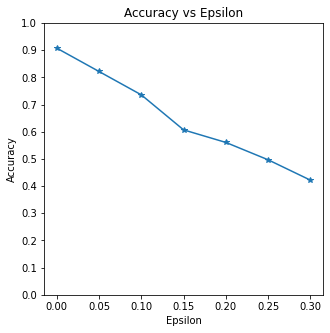

In [13]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]

#model attack
model_a = PointNet(train_dataset.num_classes)
model_a.load_state_dict(torch.load('model/pointnet.pth'))
model_a.eval()

#model test
model_t = PointNet(train_dataset.num_classes)
model_t.load_state_dict(torch.load('model/pointnet.pth'))
model_t.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attacktest(model_a, model_t, device, test_dataset, eps)
    accuracies.append(acc)
    examples.append(ex)
    
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

2) PointNet -> PointCNN

Epsilon: 0	Test Accuracy = 800 / 908 = 0.8810572687224669
Epsilon: 0.05	Test Accuracy = 768 / 908 = 0.8458149779735683
Epsilon: 0.1	Test Accuracy = 717 / 908 = 0.789647577092511
Epsilon: 0.15	Test Accuracy = 636 / 908 = 0.7004405286343612
Epsilon: 0.2	Test Accuracy = 540 / 908 = 0.5947136563876652
Epsilon: 0.25	Test Accuracy = 391 / 908 = 0.43061674008810574
Epsilon: 0.3	Test Accuracy = 278 / 908 = 0.30616740088105726


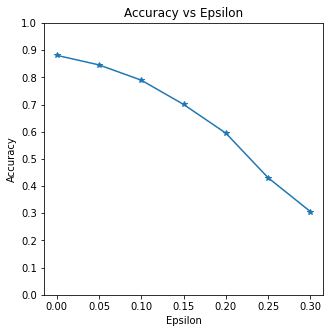

In [16]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]

#model attack
model_a = PointNet(train_dataset.num_classes)
model_a.load_state_dict(torch.load('model/pointnet.pth'))
model_a.eval()

#model test
model_t = PointCNN(train_dataset.num_classes)
model_t.load_state_dict(torch.load('model/pointcnn.pth'))
model_t.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attacktest(model_a, model_t, device, test_dataset, eps)
    accuracies.append(acc)
    examples.append(ex)
    
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

3) PointCNN -> PointCNN

Epsilon: 0	Test Accuracy = 827 / 908 = 0.9107929515418502
Epsilon: 0.05	Test Accuracy = 752 / 908 = 0.8281938325991189
Epsilon: 0.1	Test Accuracy = 703 / 908 = 0.7742290748898678
Epsilon: 0.15	Test Accuracy = 606 / 908 = 0.6674008810572687
Epsilon: 0.2	Test Accuracy = 463 / 908 = 0.5099118942731278
Epsilon: 0.25	Test Accuracy = 362 / 908 = 0.3986784140969163
Epsilon: 0.3	Test Accuracy = 240 / 908 = 0.2643171806167401


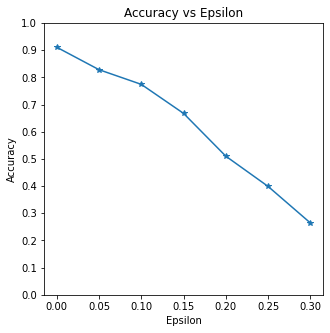

In [17]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]

#model attack
model_a = PointCNN(train_dataset.num_classes)
model_a.load_state_dict(torch.load('model/pointcnn.pth'))
model_a.eval()

#model test
model_t = PointCNN(train_dataset.num_classes)
model_t.load_state_dict(torch.load('model/pointcnn.pth'))
model_t.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attacktest(model_a, model_t, device, test_dataset, eps)
    accuracies.append(acc)
    examples.append(ex)
    
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

4) PointCNN -> PointNet

Epsilon: 0	Test Accuracy = 808 / 908 = 0.8898678414096917
Epsilon: 0.05	Test Accuracy = 773 / 908 = 0.8513215859030837
Epsilon: 0.1	Test Accuracy = 712 / 908 = 0.7841409691629956
Epsilon: 0.15	Test Accuracy = 619 / 908 = 0.6817180616740088
Epsilon: 0.2	Test Accuracy = 576 / 908 = 0.6343612334801763
Epsilon: 0.25	Test Accuracy = 495 / 908 = 0.5451541850220264
Epsilon: 0.3	Test Accuracy = 418 / 908 = 0.460352422907489


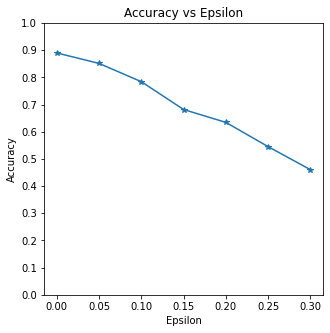

In [18]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]

#model attack
model_a = PointCNN(train_dataset.num_classes)
model_a.load_state_dict(torch.load('model/pointcnn.pth'))
model_a.eval()

#model test
model_t = PointNet(train_dataset.num_classes)
model_t.load_state_dict(torch.load('model/pointnet.pth'))
model_t.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Run test for each epsilon
for eps in epsilons:
    acc, ex = attacktest(model_a, model_t, device, test_dataset, eps)
    accuracies.append(acc)
    examples.append(ex)
    
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()